In [ ]:
#imports
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds

# Import existing architectures
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

2.4.1


In [ ]:
# Construct a tf.data.Dataset
(train_set, test_set), set_info = tfds.load('oxford_iiit_pet', split=['train','test'], shuffle_files=True, as_supervised=True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0RVATI/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0RVATI/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
# Function that resizes images to 128x128 and then normalizes from uint8 to float32
def resize_and_normalize(image, label):
  image = tf.image.resize(image, (128, 128))
  return tf.cast(image, tf.float32) / 255., label

In [ ]:
# Training pipeline
train_set = train_set.map(resize_and_normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_set = train_set.cache()
# train_set = train_set.shuffle(set_info.splits['train'].num_examples)
train_set = train_set.shuffle(500)
train_set = train_set.batch(64)
train_set = train_set.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Testing pipeline
test_set = test_set.map(
    resize_and_normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_set = test_set.batch(64)
test_set = test_set.cache()
test_set = test_set.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Existing architectures with pretrained weights
trained_weights = True
existing_models = [
    ResNet50(input_shape=(128, 128, 3), include_top=False, weights='imagenet'),
    VGG16(input_shape=(128, 128, 3), include_top=False, weights='imagenet'),
    MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet'),
    DenseNet201(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    ]

# Existing architectures without pretrained weights
# trained_weights = False
# existing_models = [
#     ResNet50(input_shape=(128, 128, 3), include_top=False),
#     VGG16(input_shape=(128, 128, 3), include_top=False),
#     MobileNetV2(input_shape=(128, 128, 3), include_top=False),
#     DenseNet201(input_shape=(128, 128, 3), include_top=False)
#     ]

# Create empty list to store the results in
results = []

for i, existing_model in enumerate(existing_models):

    # Set the best learning rate for this architecture
    if i == 0:
        learning_rate = 0.001
    elif i == 1:
        learning_rate = 0.005
    elif i == 2:
        learning_rate = 0.0005
    elif i == 3:
        learning_rate = 0.0005

    # Make it so that pretrained model's layers are not trained anymore
    if trained_weights == True:
        for layer in existing_model.layers:
            layer.trainable = False

    # Create a custom output for our 37 classes
    output = Flatten()(existing_model.output)
    output = Dense(37, activation='softmax')(output)

    # Add our custom output to the model
    model = Model(existing_model.input, output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    results.append(model.fit(
        train_set,
        epochs=50,
        validation_data=test_set,
    ))

74842112/74836368 [==============================] - 1s 0us/step
Epoch 1/50
58/58 [==============================] - 27s 302ms/step - loss: 3.8216 - sparse_categorical_accuracy: 0.0399 - val_loss: 3.5783 - val_sparse_categorical_accuracy: 0.0695
Epoch 2/50
58/58 [==============================] - 7s 118ms/step - loss: 3.4782 - sparse_categorical_accuracy: 0.0893 - val_loss: 3.5457 - val_sparse_categorical_accuracy: 0.0861
Epoch 3/50
58/58 [==============================] - 7s 119ms/step - loss: 3.3892 - sparse_categorical_accuracy: 0.1030 - val_loss: 3.4960 - val_sparse_categorical_accuracy: 0.0760
Epoch 4/50
58/58 [==============================] - 7s 120ms/step - loss: 3.3259 - sparse_categorical_accuracy: 0.1181 - val_loss: 3.4726 - val_sparse_categorical_accuracy: 0.0730
Epoch 5/50
58/58 [==============================] - 7s 120ms/step - loss: 3.2103 - sparse_categorical_accuracy: 0.1548 - val_loss: 3.4650 - val_sparse_categorical_accuracy: 0.0826
Epoch 6/50
58/58 [================

In [ ]:
# Plotting imports
import matplotlib.pyplot as plt
from google.colab import files
from matplotlib.pyplot import figure

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

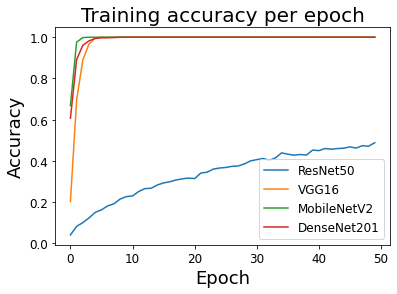

In [ ]:
# Plot the accuracy
for i,result in enumerate(results):
    if i == 0:
        plt.plot(result.history["sparse_categorical_accuracy"], label="ResNet50")
    elif i == 1:
        plt.plot(result.history["sparse_categorical_accuracy"], label="VGG16")
    elif i == 2:
        plt.plot(result.history["sparse_categorical_accuracy"], label="MobileNetV2")
    elif i == 3:
        plt.plot(result.history["sparse_categorical_accuracy"], label="DenseNet201")

plt.title("Training accuracy per epoch", fontsize=20)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.savefig("pretrained_training_acc.png")
files.download("pretrained_training_acc.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

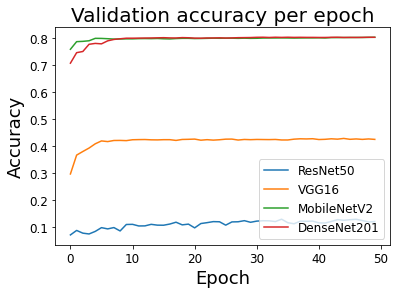

In [ ]:
# Plot the validation accuracy
for i,result in enumerate(results):
    if i == 0:
        plt.plot(result.history["val_sparse_categorical_accuracy"], label="ResNet50")
    elif i == 1:
        plt.plot(result.history["val_sparse_categorical_accuracy"], label="VGG16")
    elif i == 2:
        plt.plot(result.history["val_sparse_categorical_accuracy"], label="MobileNetV2")
    elif i == 3:
        plt.plot(result.history["val_sparse_categorical_accuracy"], label="DenseNet201")

plt.title("Validation accuracy per epoch", fontsize=20)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.savefig("pretrained_validation_acc.png")
files.download("pretrained_validation_acc.png") 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

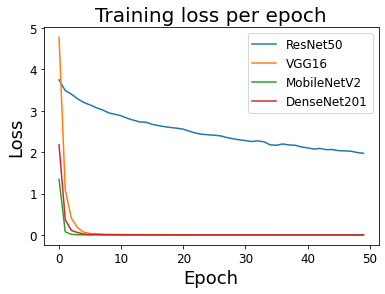

In [ ]:
# Plot the loss
for i,result in enumerate(results):
    if i == 0:
        plt.plot(result.history["loss"], label="ResNet50")
    elif i == 1:
        plt.plot(result.history["loss"], label="VGG16")
    elif i == 2:
        plt.plot(result.history["loss"], label="MobileNetV2")
    elif i == 3:
        plt.plot(result.history["loss"], label="DenseNet201")

plt.title("Training loss per epoch", fontsize=20)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.savefig("pretrained_training_loss.png")
files.download("pretrained_training_loss.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

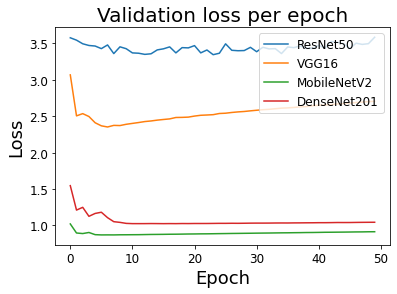

In [ ]:
# Plot the validation loss
for i,result in enumerate(results):
    if i == 0:
        plt.plot(result.history["val_loss"], label="ResNet50")
    elif i == 1:
        plt.plot(result.history["val_loss"], label="VGG16")
    elif i == 2:
        plt.plot(result.history["val_loss"], label="MobileNetV2")
    elif i == 3:
        plt.plot(result.history["val_loss"], label="DenseNet201")

plt.title("Validation loss per epoch", fontsize=20)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=1, fontsize=12)
plt.savefig("pretrained_validation_loss.png")
files.download("pretrained_validation_loss.png") 


In [ ]:
import numpy as np

for i,result in enumerate(results):
    print(i, ": \n")
    # Calculate and print the average accuracies over the last 5 epochs
    avg_acc = np.mean(result.history["sparse_categorical_accuracy"][-5:])
    avg_val_acc = np.mean(result.history["val_sparse_categorical_accuracy"][-5:])
    avg_loss = np.mean(result.history["loss"][-5:])
    avg_val_loss = np.mean(result.history["val_loss"][-5:])

    print("Average acc. = ", avg_acc)
    print("Average val. acc. = ", avg_val_acc)
    print("Average acc. = ", avg_loss)
    print("Average val. acc. = ", avg_val_loss)

0 : 

Average acc. =  0.4728260934352875
Average val. acc. =  0.12259471267461777
1 : 

Average acc. =  1.0
Average val. acc. =  0.4248024046421051
2 : 

Average acc. =  1.0
Average val. acc. =  0.8025620222091675
3 : 

Average acc. =  1.0
Average val. acc. =  0.8027800559997559
